In [1]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [2]:
import utils
from google.colab.patches import cv2_imshow

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from keras import layers
from keras.callbacks import TensorBoard, LearningRateScheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#import efficientnet.keras as efn 
from utils import *
from keras.models import Sequential, Model,load_model
from keras import backend as K
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout, GlobalAveragePooling2D, Lambda
#from keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from keras.initializers import glorot_uniform
import collections
import tensorflow
from tensorflow import Tensor


In [18]:
""" Global variables """
IMG_SIZE = (224,224)
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 40 # 40 classes in the Stanford40 dataset

#utils.onceSF()

""" Load Stanford40 dataset """
#Load the dataset which has already been preprocessed, set needDirectories to False if SF_train, SF_test, and SF_validation dirs already exist
train_ds, test_ds, val_ds, train_labels, test_labels, validation_labels, class_names = utils.loadSF40(img_size =  IMG_SIZE, needDirectories=False)

#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
#http://man.hubwiz.com/docset/TensorFlow_2.docset/Contents/Resources/Documents/tf/data/Dataset.html 


Streaming output truncated to the last 5000 lines.
  inflating: Stanford40/JPEGImages/phoning_216.jpg  
  inflating: Stanford40/JPEGImages/phoning_217.jpg  
  inflating: Stanford40/JPEGImages/phoning_218.jpg  
  inflating: Stanford40/JPEGImages/phoning_219.jpg  
  inflating: Stanford40/JPEGImages/phoning_220.jpg  
  inflating: Stanford40/JPEGImages/phoning_221.jpg  
  inflating: Stanford40/JPEGImages/phoning_222.jpg  
  inflating: Stanford40/JPEGImages/phoning_223.jpg  
  inflating: Stanford40/JPEGImages/phoning_224.jpg  
  inflating: Stanford40/JPEGImages/phoning_225.jpg  
  inflating: Stanford40/JPEGImages/phoning_226.jpg  
  inflating: Stanford40/JPEGImages/phoning_227.jpg  
  inflating: Stanford40/JPEGImages/phoning_228.jpg  
  inflating: Stanford40/JPEGImages/phoning_229.jpg  
  inflating: Stanford40/JPEGImages/phoning_230.jpg  
  inflating: Stanford40/JPEGImages/phoning_231.jpg  
  inflating: Stanford40/JPEGImages/phoning_232.jpg  
  inflating: Stanford40/JPEGImages/phoning_233.j

In [19]:
""" One-hot encoding """

def onehot_encoding(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

#Apply one hot encoding to the different datasets
train_ds = train_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(onehot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
#val_ds = val_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(onehot_encoding)
#test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)

print("Done one-hot encoding!")


Done one-hot encoding!


In [20]:
len(test_ds) * 32

5536

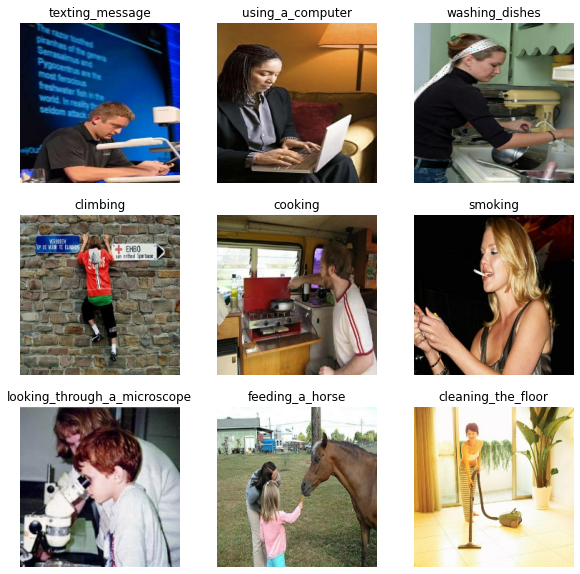

In [6]:
#Visualize Data1
def format_label(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]
    #return string_label.split("-")[1]

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title("{}".format(format_label(label[i])))
    plt.axis("off")

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [31]
(224, 224, 3)
texting_message


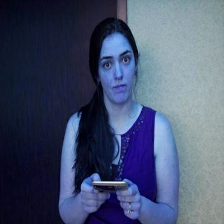

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(40,), dtype=float32)
indexis:  [14]
(224, 224, 3)
holding_an_umbrella


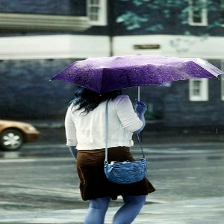

In [ ]:
#Visualize data2
import matplotlib.pyplot as plt


for images, labels in train_ds.take(2):
  print(labels[0])
  index=[i for i, e in enumerate(labels[0]) if e == 1]
  print("indexis: ",index)
  print(images[0].shape)
  print(class_names[index[0]])
  cv2_imshow(images[0].numpy().astype("uint8"))

In [9]:
class ResnetBlock(Model):  #Resnet18
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs
        
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = Sequential([
        layers.Rescaling(scale=1./255),
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE)



model = ResNet18(40) #
model.build(input_shape = (None,224,224,3))
# Initialise the model. Compule and show summary. 

#Fetch image augmentation layers and apply to inputs

model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"])
#model = create_res_net()
model.summary()

Model: "res_net18_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_120 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_48 (ResnetBloc  multiple                 74368     
 k)                                                              
                                                                 
 resnet_block_49 (ResnetBloc  multiple                 74368     
 k)                                                    

In [23]:
len(train_ds) * 32

3616

In [ ]:
# #Baseline model architecture
# bl_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(224,224,3)),
#     tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation='relu'),
#     tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
#     tf.keras.layers.Flatten(),                     
#     tf.keras.layers.Dense(units=4096, activation='relu'),
#     tf.keras.layers.Dense(units=4096, activation='relu'),
#     tf.keras.layers.Dense(units=40, activation='softmax')
# ])
#bl_model = ResNet50(input_shape=(224, 224, 3))
#bl_model = Res_Net_Model(224,224,3,40)

In [ ]:
# headModel = bl_model.output
# headModel = Flatten()(headModel)
# headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
# headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
# headModel = Dense( 40,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
# model = Model(inputs=bl_model.input, outputs=headModel)

In [ ]:
#bl_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 224, 224, 16  2368        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 activation_229 (Activation)    (None, 224, 224, 16  0           ['conv2d_5[0][0]']               
                                )                                                           

In [24]:
#Compiling and fitting Maxpool model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ResNet18_1", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1, save_format="tf")
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')

In [26]:
#hist = bl_model.fit_generator(steps_per_epoch=3200,generator=train_ds, validation_data= val_ds, validation_steps=10,epochs=100,callbacks=[checkpoint,early])
model_history=model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint,early])

Epoch 1/30
113/113 [==============================] - ETA: 0s - loss: 3.6955 - accuracy: 0.0750
Epoch 1: val_accuracy improved from -inf to 0.03750, saving model to ResNet18_1
INFO:tensorflow:Assets written to: ResNet18_1/assets
113/113 [==============================] - 25s 197ms/step - loss: 3.6955 - accuracy: 0.0750 - val_loss: 15.3460 - val_accuracy: 0.0375
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 3.2453 - accuracy: 0.1328
Epoch 2: val_accuracy improved from 0.03750 to 0.07250, saving model to ResNet18_1
INFO:tensorflow:Assets written to: ResNet18_1/assets
113/113 [==============================] - 22s 193ms/step - loss: 3.2453 - accuracy: 0.1328 - val_loss: 4.3744 - val_accuracy: 0.0725
Epoch 3/30
113/113 [==============================] - ETA: 0s - loss: 3.0532 - accuracy: 0.1758
Epoch 3: val_accuracy improved from 0.07250 to 0.11250, saving model to ResNet18_1
INFO:tensorflow:Assets written to: ResNet18_1/assets
113/113 [=============================

In [6]:
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet18_1")
#model.save('/content/drive/MyDrive/Colab Notebooks/ResNet18_1')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


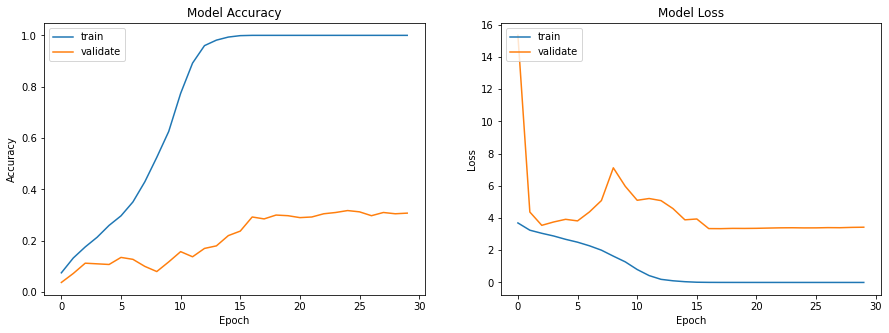

In [37]:
#Plot loss and accuracy
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(model_history.history.keys())
plotmodelhistory(model_history)

In [7]:
## Evaluation

ModelLoss, ModelAccuracy = model.evaluate(test_ds)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

173/173 [==============================] - 20s 62ms/step - loss: 3.6728 - accuracy: 0.2778
Model Loss is 3.6728193759918213
Model Accuracy is 0.2778380215167999


In [40]:
Y_pred = np.argmax(model.predict(test_ds),axis=1) 
print(Y_pred.shape)
print(Y_pred)
#convert to string label
# labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
str_pred = [class_names[i] for i in Y_pred]
#str_pred = [labels[i] for i in Y_pred]
#str_pred
# sub["label"] = pd.DataFrame(str_pred)

(5532,)
[ 2  6  3 ... 24 15 28]


In [39]:
#Visualize Data after prediction
def format_label(label):
    #index=[i for i, e in enumerate(label) if e == 1]
    return class_names[label]
    #return string_label.split("-")[1]

def format_label_original(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]


# str_pred = [class_names[i] for i in Y_pred]
# print(str_pred)


#result = test_labels.unbatch()
#labels = np.asarray(list(result.map(lambda x, y: y)))

print("Predicted labels strings: ",str_pred[0])
print("Tested labels strings: ",test_labels[0])
#labels=labels.flatten()
#labels=labels.reshape(-1)
#print(len(test_labels))
#ax = sns.heatmap(confusion_matrix(test_labels,str_pred), cmap="YlGnBu",annot=True,fmt="d")


# images = np.asarray(list(result.map(lambda x, y: x)))
# labels = np.asarray(list(result.map(lambda x, y: y)))

#cv2_imshow(images[0].numpy().astype("uint8"))

# print(labels.shape)
# for i, (image, label) in enumerate(train_ds.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image[i].numpy().astype("uint8"))
#     plt.title("{}".format(format_label(Y_pred[i])))
#     plt.axis("off")

#plt.imshow(test_ds[0].numpy().astype("uint8"))

#test_ds.shape
# plt.figure(figsize=(10,10))
# for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image[i].numpy().astype("uint8"))
#     plt.title("{}".format(format_label(Y_pred[i])))
#     plt.axis("off")
#     print(label.shape)
#print(Y_pred[0])


Predicted labels strings:  climbing
Tested labels strings:  applauding


In [ ]:
# plt.imshow(images[2].astype("uint8"))
# print("Predicted label: ",format_label(Y_pred[2]))
# print("Original label: ",format_label_original(labels[2]))

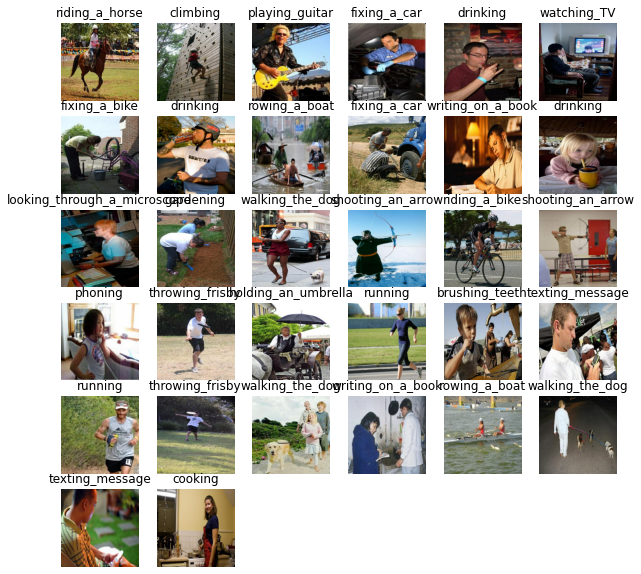

In [17]:
#Visualize Data1
def format_label(label):
    index=[i for i, e in enumerate(label) if e == 1]
    return class_names[index[0]]
    #return string_label.split("-")[1]

plt.figure(figsize=(10,10))
for i, (images, labels) in enumerate(test_ds.take(1)):
  for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

# Plotting the images
plt.show()

In [ ]:
""" Build & Train Stanford40 Model EfficientNet"""

# Define the input and output layers of the model 
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

#Fetch image augmentation layers and apply to inputs
img_augmentation = dataAugmentation()
x = img_augmentation(inputs)

outputs = efn.EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x) #Include top set to true as we are not using pre-trained weights but training from scratch


optimizer = tf.keras.optimizers.Adam(learning_rate=tf.Variable(0.01), beta_1=tf.Variable(0.9), beta_2=tf.Variable(0.999), epsilon=tf.Variable(1e-7),)
optimizer.iterations
optimizer.decay = tf.Variable(0.0)

# Initialise the model. Compule and show summary. 
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


#Fit the model with the data augmentation and normalisation iterators    ### , steps_per_epoch = NO_TRAIN_IMGS//BATCH_SIZE ## validation_steps=NO_VAL_IMGS//BATCH_SIZE, 
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, verbose=2)

#Save weights and model as we need these for transfer learning 
model.save_weights("model_weights", save_format='tf')
tf.keras.models.save_model(model, "SF_model", include_optimizer=True, save_format='tf')



#Plot loss and accuracy
plotAccuracy("Accuracy on Stanford 40", history.history['accuracy'], history.history['val_accuracy'])                     # made these plotting functions in utils for hassle-free plotting
plotLoss("Accuracy on Stanford 40", history.history['loss'], history.history['val_loss'])



AttributeError: ignored

In [ ]:
tf.keras.models.save_model(model, "NoOptimiser", include_optimizer=False, save_format='tf')

INFO:tensorflow:Assets written to: NoOptimiser/assets


In [ ]:
#Zip and download the model
!zip -r /content/SF_model.zip /content/SF_model
from google.colab import files
files.download("SF_model.zip")

  adding: content/SF_model/ (stored 0%)
  adding: content/SF_model/keras_metadata.pb (deflated 96%)
  adding: content/SF_model/saved_model.pb (deflated 91%)
  adding: content/SF_model/variables/ (stored 0%)
  adding: content/SF_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/SF_model/variables/variables.index (deflated 74%)
  adding: content/SF_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Zip and download the model
!zip -r /content/NoOptimiser.zip /content/NoOptimiser
from google.colab import files
files.download("NoOptimiser.zip")

  adding: content/NoOptimiser/ (stored 0%)
  adding: content/NoOptimiser/keras_metadata.pb (deflated 96%)
  adding: content/NoOptimiser/saved_model.pb (deflated 91%)
  adding: content/NoOptimiser/variables/ (stored 0%)
  adding: content/NoOptimiser/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/NoOptimiser/variables/variables.index (deflated 74%)
  adding: content/NoOptimiser/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" Tutorials used to build model"""
#https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
#https://towardsdatascience.com/an-in-depth-efficientnet-tutorial-using-tensorflow-how-to-use-efficientnet-on-a-custom-dataset-1cab0997f65c
#https://www.kaggle.com/code/arjunrao2000/beginners-guide-efficientnet-with-keras/notebook

""" Cyclical learning rate example"""
#https://pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/